In [77]:
from __future__ import division
from __future__ import print_function

import matplotlib

import pandas
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_style("white")
import sys
sys.path.append('../modules/')
from Processors import *

In [30]:
loc = '../data_n/'

energies = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]

signalData = []
backgroundData = []

for energy in energies:
    signalData.append(pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + 
                                      str(energy) + "_narrow_13TeV-madgraph.csv"))

# same as 2 but only the first half of the events
#backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_1.csv"))
backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV.csv"))
backgroundData.append(pandas.read_csv(loc + "WJetsToLNu_TuneCUETP8M1_13TeV.csv"))


# drop columns without header
for signal_data in signalData:
    signal_data.drop([x for x in signal_data.columns if 'Unnamed' in x], axis=1, inplace=True)

for background_data in backgroundData:
    background_data.drop([x for x in background_data.columns if 'Unnamed' in x], axis=1, inplace=True)

allSignalData = signalData[0]
for signal_data in signalData[1:]:
    allSignalData = allSignalData.append(signal_data, ignore_index=True)

allBackgroundData = backgroundData[0]
for background_data in backgroundData[1:]:
    allBackgroundData = allBackgroundData.append(background_data, ignore_index=True)

for i in range(len(energies)):
    print("{} events for Higgs with {} GeV".format(len(signalData[i]), energies[i]))
print("{} TT_Tune events".format(len(backgroundData[0])))
print("{} WJetsToLNu_Tune events".format(len(backgroundData[1])), end='\n\n')
print("{} events of Higgs".format(len(allSignalData)))
print("{} background events".format(len(allBackgroundData)))

403 events for Higgs with 260 GeV
394 events for Higgs with 270 GeV
390 events for Higgs with 280 GeV
372 events for Higgs with 300 GeV
479 events for Higgs with 320 GeV
655 events for Higgs with 400 GeV
1619 events for Higgs with 500 GeV
1858 events for Higgs with 550 GeV
2008 events for Higgs with 600 GeV
2239 events for Higgs with 700 GeV
166157 TT_Tune events
1896 WJetsToLNu_Tune events

10417 events of Higgs
168053 background events


In [31]:
# add column for classification
#allSignalData['gen_classification'] = np.ones(len(allSignalData))
#allBackgroundData['gen_classification'] = np.zeros(len(allBackgroundData))

allData = allSignalData.append(allBackgroundData, ignore_index=True)
allLabels = np.append(np.ones(len(allSignalData)),np.zeros(len(allBackgroundData)))

In [32]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(allData, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(allData, p) #Calculate energy and absolute momentum
    
moveToCartesian(allData, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(allData, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(allData, allData['t_1_pT'], allData['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

## select train variables

In [33]:
genFeatures = [var for var in allData.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in allData.columns if var not in genFeatures] #Reconstructed features; ok for training

In [34]:
pTEtaPhi = [var for var in trainFeatures for x in ['phi','eta', 't_1_mass'] if x in var] # 'pT', 'eta', 
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi]

In [35]:
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']

In [36]:
classTrainFeatures = fsFeatures
print("Training on {} features {}". format(len(classTrainFeatures),[var for var in classTrainFeatures]))

Training on 58 features ['t_0_pT', 't_0_mass', 't_1_pT', 'b_0_pT', 'b_0_mass', 'b_0_csv', 'b_1_pT', 'b_1_mass', 'b_1_csv', 'mPT_pT', 'h_tt_pT', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_pT', 'h_bb_mass', 'diH_pT', 'diH_mass', 'diH_kinFit_mass', 'diH_kinFit_prob', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


In [70]:
X_train, X_test, y_train, y_test = train_test_split(allData[classTrainFeatures], allLabels, test_size=0.2, random_state=2345)


35694 35694


In [38]:
scale = len(allBackgroundData)/len(allSignalData)

weights_train = np.ones(len(y_train))
weights_test = np.ones(len(y_test))

weights_train[y_train == 1] = scale
weights_test[y_test == 1] = scale

In [39]:
# fit model no training data
model = xgb.XGBClassifier(random_state=1337,  scale_pos_weight=scale, objective='binary:logistic',n_estimators=300 , eval_metric='auc')
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=1337, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=16.1325717577, seed=None,
       silent=True, subsample=1)

In [40]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [41]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy           : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=y_test)
print("Accuracy signal    : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=np.logical_not(y_test))
print("Accuracy background: {:10}%".format(accuracy * 100.0))

Accuracy           : 93.2649745055%
Accuracy signal    : 91.4786967419%
Accuracy background: 93.3707231669%


In [42]:
print(model.score(X_train, y_train, sample_weight=weights_train))
print(model.score(X_test, y_test, sample_weight=weights_test))

0.940776004421
0.924464567609


In [43]:
model.score

<bound method XGBClassifier.score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=1337, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=16.1325717577, seed=None,
       silent=True, subsample=1)>

In [79]:

pred = model.predict_proba(X_test)
back = []
sign = []
j=0;
for i in pred:
    
    if (y_test[j]==int(0)):
        back.append(i[1])
        
    if (y_test[j]==int(1)):
        sign.append(i[1])
        
    j=j+1


model.predict?

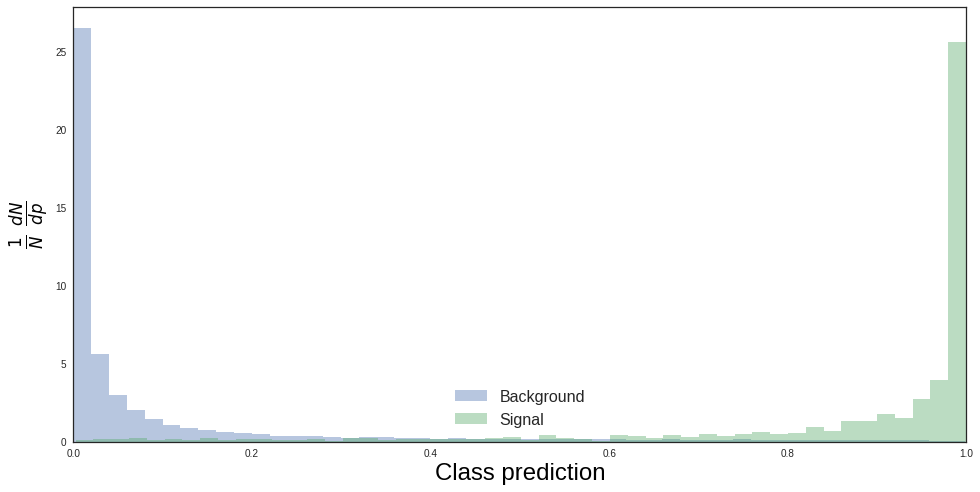

In [80]:
params = {'hist' : True, 'kde' : False, 'norm_hist' : True}
plt.figure(figsize=(16, 8))
sns.distplot(back, label='Background', **params)
sns.distplot(sign, label='Signal', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
plt.xlim([0,1])
#plt.yscale('log', nonposy='clip')
plt.show()